In [6]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.models as models
import torchvision.transforms.v2 as transforms
import lightning as L
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

In [11]:
class Model(L.LightningModule):
    def __init__(self, num_classes=100):
        super().__init__()

        weights = models.EfficientNet_B2_Weights.IMAGENET1K_V1
        self.preprocess = weights.transforms()
        backbone = models.efficientnet_b2(weights=weights)
        num_filters = 1408
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)
        self.feature_extractor.eval()
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.3, inplace=True),
            nn.Linear(num_filters, num_classes)
        )

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = self.feature_extractor(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        loss = F.cross_entropy(x, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = self.feature_extractor(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        loss = F.cross_entropy(x, y)
        self.log("val_loss", loss, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [12]:
model = Model(10)

In [15]:
dataset = MNIST(os.getcwd(), download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                    model.preprocess
                ]))

# split the train set into two
seed = torch.Generator().manual_seed(42)
train_set, valid_set, _ = data.random_split(dataset, [.02, .01, 1 - .02 - .01], generator=seed)

train_loader = data.DataLoader(train_set, batch_size=32)
val_loader = data.DataLoader(valid_set, batch_size=32)

In [16]:
trainer = L.Trainer()
trainer.fit(model, train_loader, val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type                | Params
----------------------------------------------------------
0 | preprocess        | ImageClassification | 0     
1 | feature_extractor | Sequential          | 7.7 M 
2 | classifier        | Sequential          | 14.1 K
----------------------------------------------------------
14.1 K    Trainable params
7.7 M     Non-trainable params
7.7 M     Total params
30.860    Total estimated model params size (MB)


Sanity Checking DataLoader 0:  50%|████████████████████                    | 1/2 [00:00<00:00,  2.02it/s]tensor(1.8503, device='mps:0')
                                                                                                         

/Users/keanuthakalath/Desktop/macro-tracker-9000/ml/venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (38) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|████████████████████████████████| 38/38 [00:30<00:00,  1.25it/s, v_num=2, train_loss=0.822]
Validation: |                                                                      | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|                                                    | 0/19 [00:00<?, ?it/s]tensor(0.9491, device='mps:0')

Validation DataLoader 0:   5%|██▎                                         | 1/19 [00:00<00:12,  1.41it/s]tensor(1.0166, device='mps:0')

Validation DataLoader 0:  11%|████▋                                       | 2/19 [00:01<00:12,  1.31it/s]tensor(1.0195, device='mps:0')

Validation DataLoader 0:  16%|██████▉                                     | 3/19 [00:02<00:12,  1.31it/s]tensor(1.2327, device='mps:0')

Validation DataLoader 0:  21%|█████████▎                                  | 4/19 [00:03<00:11,  1.33it/s]tensor(1.0813, device='mps:0')

Validation DataLoader 0:  26%|███████████▌                                | 5/19 [00:03<00:10,  1.31it/

In [164]:
model.cpu()
model.eval()

Model(
  (preprocess): ImageClassification(
      crop_size=[288]
      resize_size=[288]
      mean=[0.485, 0.456, 0.406]
      std=[0.229, 0.224, 0.225]
      interpolation=InterpolationMode.BICUBIC
  )
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (f

3


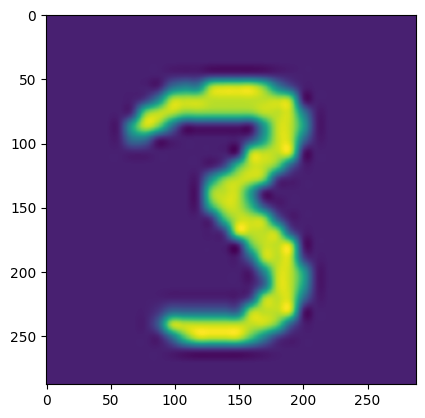

In [174]:
x, y = next(iter(val_loader))
pred = model.feature_extractor(x)
pred = torch.flatten(pred, start_dim=1)
pred = model.classifier(pred)

Label: 9 Predicted: 9


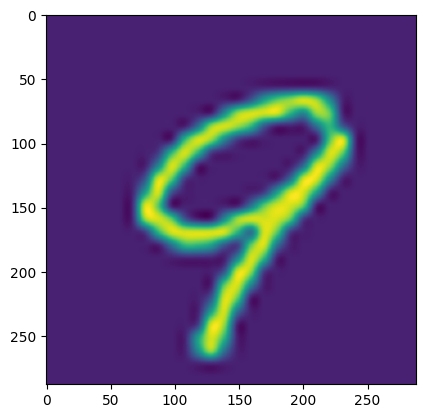

In [192]:
ex = 14
plt.imshow(x[ex][0])
print(f"Label: {y[ex].item()} Predicted: {pred[ex].argmax().item()}")